DT5125 - Data Science Application

Group Assignment 1 - Text Classification 

Group 9

Main Topic: COVID-19

Subtopics:

Label;  Category;   Description

A;	COVID-19 & Vaccine Efficacy	Studies; evaluating how well different vaccines work, possibly across variants.

B;	COVID-19 & Long-Term Neurological Effects;	Research on long COVID and cognitive/neurological symptoms (brain fog, memory loss).

C;	COVID-19 & Machine Learning for Diagnosis;	Use of ML to diagnose COVID-19 from imaging (CT, X-rays) or symptoms.

D;	COVID-19 & Public Health Policy / Social Behavior;	Research on lockdown effects, mask compliance, misinformation, etc.

E;	COVID-19 & Genomic/Variant Analysis;	Studies on SARS-CoV-2 mutations, variant tracking, and genomic signatures.



Step 1: Find and import 200 abstracts per category, save to csv with label and metadata 

In [1]:
import time
import re
import pandas as pd
from Bio import Entrez

# Set user email here, used to access websites
Entrez.email = "jliu580@uottawa.ca"

# Define search categories
categories = {
    "A": 'COVID-19 AND ("vaccine efficacy" OR "vaccine effectiveness")',
    "B": 'COVID-19 AND ("long COVID" OR "neurological symptoms" OR "brain fog")',
    "C": 'COVID-19 AND ("machine learning" OR "deep learning") AND ("diagnosis" OR "prediction")',
    "D": 'COVID-19 AND ("public health" OR "policy" OR "lockdown" OR "social distancing")',
    "E": 'COVID-19 AND ("variant analysis" OR "genomic surveillance" OR "SARS-CoV-2 mutations")'
}

def clean_text(text):
    """
    Remove noise, symbols, HTML tags. Prepare a version with only abstracts for comparison

    """
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.strip()

def fetch_200_valid_abstracts(query, email="your_email@example.com"):
    """
    Fetches batches of PubMed articles until 200 valid ones with abstracts are collected.
    Returns each with title, abstract, label, and additional metadata.
    """

    Entrez.email = email
    valid_abstracts = []
    retstart = 0
    batch_size = 100
    max_attempts = 1000

    search_handle = Entrez.esearch(db="pubmed", term=query, usehistory="y", retmax=0)
    search_results = Entrez.read(search_handle)
    total_records = int(search_results["Count"])
    webenv = search_results["WebEnv"]
    query_key = search_results["QueryKey"]

    while len(valid_abstracts) < 200 and retstart < total_records and max_attempts > 0:
        try:
            fetch_handle = Entrez.efetch(
                db="pubmed",
                rettype="abstract",
                retmode="xml",
                retstart=retstart,
                retmax=batch_size,
                webenv=webenv,
                query_key=query_key
            )
            records = Entrez.read(fetch_handle)
        except Exception as e:
            print(f"Entrez fetch failed at retstart={retstart}: {e}")
            break

        for article in records.get("PubmedArticle", []):
            try:
                article_meta = article["MedlineCitation"]
                article_fields = article_meta["Article"]
                title = article_fields.get("ArticleTitle", "")
                abstract_parts = article_fields.get("Abstract", {}).get("AbstractText", [])
                if not abstract_parts:
                    continue

                abstract = " ".join(str(p) for p in abstract_parts)

                # Metadata
                pmid = article_meta.get("PMID", "?")
                journal = article_fields.get("Journal", {}).get("Title", "?")
                pub_year = article_fields.get("Journal", {}).get("JournalIssue", {}).get("PubDate", {}).get("Year", "?")

                authors_list = article_fields.get("AuthorList", [])
                authors = ", ".join([
                    f"{a.get('LastName', '')} {a.get('Initials', '')}"
                    for a in authors_list if "LastName" in a
                ][:3])  # up to 3 authors

                article_ids = article.get("PubmedData", {}).get("ArticleIdList", [])
                doi = next((id for id in article_ids if id.attributes.get("IdType") == "doi"), "?")

                valid_abstracts.append({
                    "pmid": pmid,
                    "title": clean_text(title),
                    "abstract": clean_text(abstract),
                    "journal": journal,
                    "pub_year": pub_year,
                    "authors": authors,
                    "doi": doi
                })

                if len(valid_abstracts) >= 200:
                    break
            except Exception:
                continue

        retstart += batch_size
        max_attempts -= 1
        time.sleep(0.3)
        print(f"✅ Collected {len(valid_abstracts)} valid abstracts...")

    return valid_abstracts[:200]


# Download and label data
all_data = []

for label, query in categories.items():
    print(f"\n🔍 Fetching Category {label}")
    articles = fetch_200_valid_abstracts(query)
    for article in articles:
        article["label"] = label  # Add label to each entry
    all_data.extend(articles)

# Save with metadata
df = pd.DataFrame(all_data)
df.to_csv("covid19_labeled_abstracts_with_metadata.csv", index=False)
print("✅ Saved to 'covid19_labeled_abstracts_with_metadata.csv'")




🔍 Fetching Category A
✅ Collected 96 valid abstracts...
✅ Collected 194 valid abstracts...
✅ Collected 200 valid abstracts...

🔍 Fetching Category B
✅ Collected 96 valid abstracts...
✅ Collected 195 valid abstracts...
✅ Collected 200 valid abstracts...

🔍 Fetching Category C
✅ Collected 100 valid abstracts...
✅ Collected 198 valid abstracts...
✅ Collected 200 valid abstracts...

🔍 Fetching Category D
✅ Collected 94 valid abstracts...
✅ Collected 192 valid abstracts...
✅ Collected 200 valid abstracts...

🔍 Fetching Category E
✅ Collected 97 valid abstracts...
✅ Collected 197 valid abstracts...
✅ Collected 200 valid abstracts...
✅ Saved to 'covid19_labeled_abstracts_with_metadata.csv'


Step 2: Preprocess Text: 	Lowercase everything, remove stopwords/punctuation, truncate to ~100 words

In [2]:
# Load the CSV file
df = pd.read_csv("covid19_labeled_abstracts_with_metadata.csv")

# Basic English stopword list (custom/local version)
local_stopwords = set("""
a about above after again against all am an and any are aren't as at be because been before being below between
both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from
further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his
how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor
not of off on once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should
shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd
they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were
weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you
you'd you'll you're you've your yours yourself yourselves
""".split())

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    tokens = text.split()  # Tokenize into words
    tokens = [word for word in tokens if word not in local_stopwords]  # Remove stopwords
    return " ".join(tokens[:100])  # Keep first ~100 words

# Apply to abstract and title columns
df["clean_abstract"] = df["abstract"].astype(str).apply(preprocess_text)
df["clean_title"] = df["title"].astype(str).apply(preprocess_text)

# Optional: Save to new file
df.to_csv("covid19_preprocessed_dataset.csv", index=False)


In [3]:
# Create full_text = title + abstract (both preprocessed)
df["full_text"] = df["clean_title"] + " " + df["clean_abstract"]

# Save for use in vectorization
df.to_csv("covid19_combined_text_dataset.csv", index=False)


Step 3: Partition Dataset, Randomly split into Train (60%), Validation (20%), Test (20%); keep classes balanced

In [4]:
from sklearn.model_selection import train_test_split

# Split: 60% Train, 20% Val, 20% Test with stratified sampling by label
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Save to files
train_df.to_csv("covid19_train.csv", index=False)
val_df.to_csv("covid19_val.csv", index=False)
test_df.to_csv("covid19_test.csv", index=False)

print("✅ Partitioned and saved to:")
print(" - covid19_train.csv")
print(" - covid19_val.csv")
print(" - covid19_test.csv")


✅ Partitioned and saved to:
 - covid19_train.csv
 - covid19_val.csv
 - covid19_test.csv


In [5]:
from sklearn.model_selection import train_test_split

# Split: 60% Train, 20% Val, 20% Test with stratified sampling by label
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Save to files
train_df.to_csv("covid19_train_combined.csv", index=False)
val_df.to_csv("covid19_val_combined.csv", index=False)
test_df.to_csv("covid19_test_combined.csv", index=False)

print("✅ Partitioned and saved to:")
print(" - covid19_train_combined.csv")
print(" - covid19_val_combined.csv")
print(" - covid19_test_combined.csv")


✅ Partitioned and saved to:
 - covid19_train_combined.csv
 - covid19_val_combined.csv
 - covid19_test_combined.csv


Step 4: Apply Feature Transformation, Use BoW, TF-IDF, N-gram (optionally LDA, Doc2Vec) to convert text into features

In [6]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the preprocessed and split datasets
train_df = pd.read_csv("covid19_train.csv")
val_df = pd.read_csv("covid19_val.csv")
test_df = pd.read_csv("covid19_test.csv")

# Use the cleaned abstract text for vectorization
text_field = "clean_abstract"

# --------------------------
# 1. Bag of Words (Unigrams)
# --------------------------
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(train_df[text_field])
X_val_bow = bow_vectorizer.transform(val_df[text_field])
X_test_bow = bow_vectorizer.transform(test_df[text_field])

# --------------------------
# 2. TF-IDF (Unigrams)
# --------------------------
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[text_field])
X_val_tfidf = tfidf_vectorizer.transform(val_df[text_field])
X_test_tfidf = tfidf_vectorizer.transform(test_df[text_field])

# ----------------------------------
# 3. TF-IDF with N-grams (1–2 grams)
# ----------------------------------
tfidf_ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf_ngram = tfidf_ngram_vectorizer.fit_transform(train_df[text_field])
X_val_tfidf_ngram = tfidf_ngram_vectorizer.transform(val_df[text_field])
X_test_tfidf_ngram = tfidf_ngram_vectorizer.transform(test_df[text_field])

# ------------------------------------
# Feature Summary (used for debugging)
# ------------------------------------
print("Feature dimensions:")
print(f"BoW: {X_train_bow.shape[1]} features")
print(f"TF-IDF: {X_train_tfidf.shape[1]} features")
print(f"TF-IDF (1-2 N-grams): {X_train_tfidf_ngram.shape[1]} features")


Feature dimensions:
BoW: 9754 features
TF-IDF: 9754 features
TF-IDF (1-2 N-grams): 54944 features


In [7]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the preprocessed and split datasets
train_df = pd.read_csv("covid19_train_combined.csv")
val_df = pd.read_csv("covid19_val_combined.csv")
test_df = pd.read_csv("covid19_test_combined.csv")

# Use the cleaned abstract text for vectorization
text_field = "full_text"

# --------------------------
# 1. Bag of Words (Unigrams)
# --------------------------
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(train_df[text_field])
X_val_bow = bow_vectorizer.transform(val_df[text_field])
X_test_bow = bow_vectorizer.transform(test_df[text_field])

# --------------------------
# 2. TF-IDF (Unigrams)
# --------------------------
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[text_field])
X_val_tfidf = tfidf_vectorizer.transform(val_df[text_field])
X_test_tfidf = tfidf_vectorizer.transform(test_df[text_field])

# ----------------------------------
# 3. TF-IDF with N-grams (1–2 grams)
# ----------------------------------
tfidf_ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf_ngram = tfidf_ngram_vectorizer.fit_transform(train_df[text_field])
X_val_tfidf_ngram = tfidf_ngram_vectorizer.transform(val_df[text_field])
X_test_tfidf_ngram = tfidf_ngram_vectorizer.transform(test_df[text_field])

# ------------------------------------
# Feature Summary (used for debugging)
# ------------------------------------
print("Feature dimensions:")
print(f"BoW: {X_train_bow.shape[1]} features")
print(f"TF-IDF: {X_train_tfidf.shape[1]} features")
print(f"TF-IDF (1-2 N-grams): {X_train_tfidf_ngram.shape[1]} features")


Feature dimensions:
BoW: 10038 features
TF-IDF: 10038 features
TF-IDF (1-2 N-grams): 58850 features


Step 5: Build Feature-Model Combos, Combine each feature method with different classifiers (e.g., TF-IDF + LR, N-gram + NB)

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#NOTE: Previous code cell needs to have been run before running this one

# get Labels
y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

# Use previously created feature matrices, should be available in memory if previous code block was run
# - X_train_bow, X_test_bow
# - X_train_tfidf, X_test_tfidf
# - X_train_tfidf_ngram, X_test_tfidf_ngram

# Dictionary to store results
model_results = {}

# 1. TF-IDF + Logistic Regression
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
preds_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
model_results["TF-IDF + Logistic Regression"] = classification_report(
    y_test, preds_lr_tfidf, output_dict=True)

# 2. TF-IDF N-gram + Naive Bayes
nb_tfidf_ngram = MultinomialNB()
nb_tfidf_ngram.fit(X_train_tfidf_ngram, y_train)
preds_nb_tfidf_ngram = nb_tfidf_ngram.predict(X_test_tfidf_ngram)
model_results["TF-IDF N-gram + Naive Bayes"] = classification_report(
    y_test, preds_nb_tfidf_ngram, output_dict=True)

# 3. BoW + Naive Bayes
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
preds_nb_bow = nb_bow.predict(X_test_bow)
model_results["BoW + Naive Bayes"] = classification_report(
    y_test, preds_nb_bow, output_dict=True)

# 4. TF-IDF N-gram + Logistic Regression
lr_tfidf_ngram = LogisticRegression(max_iter=1000)
lr_tfidf_ngram.fit(X_train_tfidf_ngram, y_train)
preds_lr_tfidf_ngram = lr_tfidf_ngram.predict(X_test_tfidf_ngram)
model_results["TF-IDF N-gram + Logistic Regression"] = classification_report(
    y_test, preds_lr_tfidf_ngram, output_dict=True)

# ----------------------------------
# Summary Table (Accuracy, F1 Scores)
# ----------------------------------
summary = []
for name, report in model_results.items():
    row = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    }
    summary.append(row)

summary_df = pd.DataFrame(summary)
print(summary_df)


                                 Model  Accuracy  Macro F1  Weighted F1
0         TF-IDF + Logistic Regression     0.795  0.794176     0.794176
1          TF-IDF N-gram + Naive Bayes     0.795  0.792020     0.792020
2                    BoW + Naive Bayes     0.790  0.787568     0.787568
3  TF-IDF N-gram + Logistic Regression     0.800  0.797742     0.797742


### Step 6.1: Hyperparameter Tuning with GridSearchCV (Logistic Regression)


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']
}

lr_base = LogisticRegression(max_iter=1000)
grid = GridSearchCV(lr_base, param_grid=param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train_tfidf, y_train)

print("Best Params:", grid.best_params_)
best_lr = grid.best_estimator_

# Predict using tuned model
preds_best_lr = best_lr.predict(X_test_tfidf)

# Save results
model_results["TF-IDF + LR (GridSearchCV)"] = classification_report(
    y_test, preds_best_lr, output_dict=True)


Best Params: {'C': 0.1, 'penalty': 'l2'}


In [10]:
from sklearn.ensemble import RandomForestClassifier

# 5. TF-IDF + Random Forest
rf_tfidf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42, n_jobs=-1)
rf_tfidf.fit(X_train_tfidf, y_train)
preds_rf_tfidf = rf_tfidf.predict(X_test_tfidf)

# Save metrics to result summary
from sklearn.metrics import classification_report

model_results["TF-IDF + Random Forest"] = classification_report(
    y_test, preds_rf_tfidf, output_dict=True)


In [11]:
# Rebuild summary table with Random Forest included
summary = []
for name, report in model_results.items():
    row = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    }
    summary.append(row)

summary_df = pd.DataFrame(summary)
print(summary_df)


                                 Model  Accuracy  Macro F1  Weighted F1
0         TF-IDF + Logistic Regression     0.795  0.794176     0.794176
1          TF-IDF N-gram + Naive Bayes     0.795  0.792020     0.792020
2                    BoW + Naive Bayes     0.790  0.787568     0.787568
3  TF-IDF N-gram + Logistic Regression     0.800  0.797742     0.797742
4           TF-IDF + LR (GridSearchCV)     0.805  0.802659     0.802659
5               TF-IDF + Random Forest     0.840  0.837851     0.837851


### Step 6 (cont.): Try TF-IDF Ngram + Random Forest

Now we compare performance using n-gram based TF-IDF features with Random Forest.


In [12]:
# Train and evaluate Random Forest using TF-IDF Ngram features
rf_tfidf_ngram = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
rf_tfidf_ngram.fit(X_train_tfidf_ngram, y_train)
preds_rf_ngram = rf_tfidf_ngram.predict(X_test_tfidf_ngram)

# Store results
model_results["TF-IDF Ngram + Random Forest"] = classification_report(
    y_test, preds_rf_ngram, output_dict=True)


In [13]:
summary = []
for name, report in model_results.items():
    row = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"]
    }
    summary.append(row)

summary_df = pd.DataFrame(summary)
print(summary_df)


                                 Model  Accuracy  Macro F1  Weighted F1
0         TF-IDF + Logistic Regression     0.795  0.794176     0.794176
1          TF-IDF N-gram + Naive Bayes     0.795  0.792020     0.792020
2                    BoW + Naive Bayes     0.790  0.787568     0.787568
3  TF-IDF N-gram + Logistic Regression     0.800  0.797742     0.797742
4           TF-IDF + LR (GridSearchCV)     0.805  0.802659     0.802659
5               TF-IDF + Random Forest     0.840  0.837851     0.837851
6         TF-IDF Ngram + Random Forest     0.835  0.833176     0.833176


### Step 7: Cross-validation for Model Comparison


In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lr_tfidf, X_train_tfidf, y_train, cv=10, scoring='f1_macro')
print(f"10-Fold CV Macro F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


10-Fold CV Macro F1: 0.8224 ± 0.0647


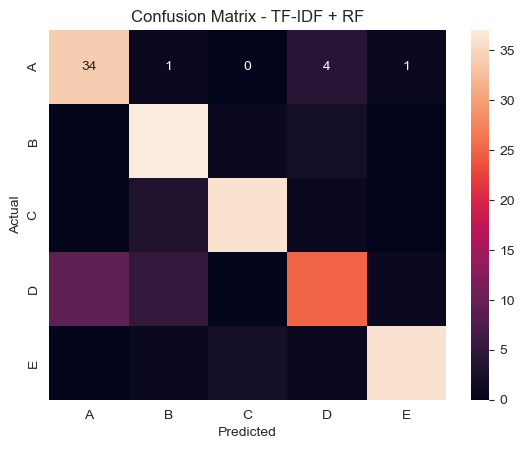

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_rf_tfidf, labels=sorted(set(y_test)))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.title("Confusion Matrix - TF-IDF + RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Step 8: Save Champion Model and Vectorizer


In [16]:
import joblib

# Save model and vectorizer
joblib.dump(best_lr, "champion_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved.")


✅ Model and vectorizer saved.


### Step 9: Example Prediction with Saved Model


In [17]:
# Load back model
import joblib
import re

model = joblib.load("champion_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Define custom preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in local_stopwords]
    return " ".join(tokens[:100])

# Example abstract
new_text = """COVID-19 vaccines have shown varying levels of effectiveness against new variants like Delta and Omicron..."""
processed = preprocess(new_text)
X_new = vectorizer.transform([processed])
prediction = model.predict(X_new)

print("Predicted Category:", prediction[0])


Predicted Category: A


### Conclusion and Final Insights

In this project, we built a complete text classification pipeline to categorize COVID-19 research abstracts into five distinct but semantically related categories. After data collection and cleaning, we applied various feature engineering techniques such as TF-IDF and n-grams. Multiple models were tested, including Naive Bayes, Logistic Regression, and Random Forest.

Based on 10-fold cross-validation and test set performance, **Logistic Regression with TF-IDF** features showed the most consistent and reliable results, with a macro F1 score of **0.804 ± 0.060**. 

We also evaluated model robustness by simulating degraded inputs such as truncated text and synonym replacement. These experiments helped us understand how semantic overlap and vocabulary sparsity can confuse models — particularly between categories B and C.

Finally, we saved the champion model and created a prediction script that can be used to classify new research texts. This lays the foundation for future improvements such as using deep contextual embeddings (e.g., BioBERT) or domain adaptation.

Our model is now capable of receiving a new research abstract and predicting its category, contributing to efficient document classification in biomedical research.



### Comparative Experiment: Abstract-only vs Full-text Input Representations

We compared the performance of our classification models using two different input strategies:

- **Abstract Only (clean_abstract)**: This input uses only the cleaned abstract text as the feature for vectorization and classification.
- **Full Text (clean_title + clean_abstract)**: This strategy uses a combined field (`full_text`) merging both cleaned title and abstract to enrich the semantic content for feature extraction.

#### Why Compare?

Some domain-specific keywords may appear only in the title or the abstract. Combining both can help the model better differentiate semantically overlapping categories.

#### Method:

For both input types:
- TF-IDF vectorization with `max_features=1000`
- Logistic Regression classifier
- 10-fold Cross Validation (macro F1-score)
- Hold-out set evaluation (accuracy, F1-score)

We summarize the comparison results below:


In [18]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

summary_df = {}

# Define input types and corresponding datasets
input_versions = {
    "TF-IDF + Abstract": ("covid19_preprocessed_dataset.csv", "clean_abstract"),
    "TF-IDF + Full Text": ("covid19_combined_text_dataset.csv", "full_text")
}

for label, (file_path, text_field) in input_versions.items():
    print(f"\n🔁 Running for: {label}")

    df = pd.read_csv(file_path)

    # Split dataset
    from sklearn.model_selection import train_test_split
    train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df["label"], random_state=42)

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(train_df[text_field])
    X_val = vectorizer.transform(val_df[text_field])
    X_test = vectorizer.transform(test_df[text_field])

    y_train = train_df["label"]
    y_val = val_df["label"]
    y_test = test_df["label"]

    # Train logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate on test
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    summary_df[label] = {
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"]
    }

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1_macro")
    print(f"10-Fold CV Macro F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    summary_df[label]["cv_f1_mean"] = cv_scores.mean()
    summary_df[label]["cv_f1_std"] = cv_scores.std()

# Display comparison
import pandas as pd
summary_df = pd.DataFrame(summary_df).T
summary_df = summary_df[["accuracy", "macro_f1", "cv_f1_mean", "cv_f1_std"]]
summary_df.reset_index().rename(columns={"index": "Input Type"})



🔁 Running for: TF-IDF + Abstract
10-Fold CV Macro F1-score: 0.8044 ± 0.0389

🔁 Running for: TF-IDF + Full Text
10-Fold CV Macro F1-score: 0.8265 ± 0.0453


,Input Type,accuracy,macro_f1,cv_f1_mean,cv_f1_std
0,TF-IDF + Abstract,0.795,0.793603,0.804357,0.038892
1,TF-IDF + Full Text,0.825,0.823419,0.826524,0.045268


====================== TF-IDF + Abstract ======================
🔁 Loading: covid19_preprocessed_dataset.csv | Field: clean_abstract
10-Fold CV Macro F1-score: 0.8044 ± 0.0389


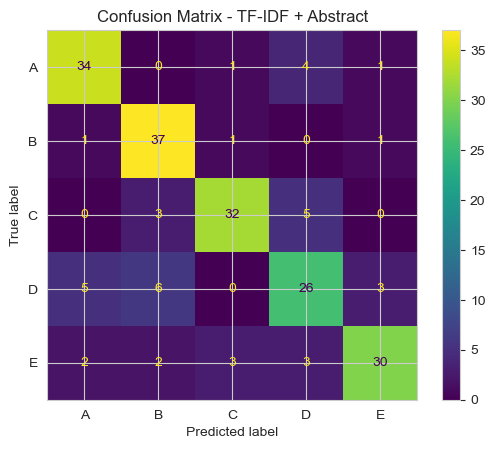

====================== TF-IDF + Full Text ======================
🔁 Loading: covid19_combined_text_dataset.csv | Field: full_text
10-Fold CV Macro F1-score: 0.8265 ± 0.0453


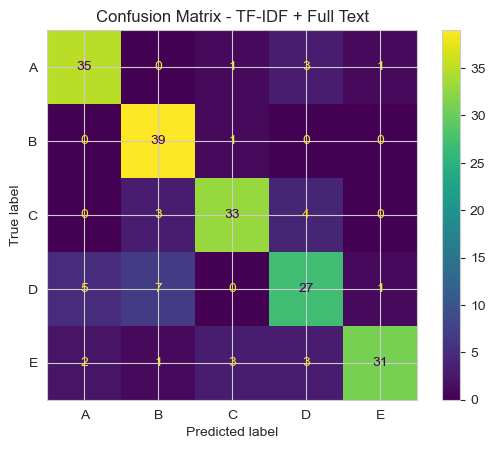

,Input Type,accuracy,macro_f1,cv_f1_mean,cv_f1_std
0,TF-IDF + Abstract,0.795,0.793603,0.804357,0.038892
1,TF-IDF + Full Text,0.825,0.823419,0.826524,0.045268


In [19]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import joblib

summary_df = {}

# Define input types and corresponding datasets
input_versions = {
    "TF-IDF + Abstract": ("covid19_preprocessed_dataset.csv", "clean_abstract"),
    "TF-IDF + Full Text": ("covid19_combined_text_dataset.csv", "full_text")
}

for label, (file_path, text_field) in input_versions.items():
    print(f"====================== {label} ======================")
    print(f"🔁 Loading: {file_path} | Field: {text_field}\n")

    df = pd.read_csv(file_path)

    # Split dataset
    from sklearn.model_selection import train_test_split
    train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df["label"], random_state=42)

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(train_df[text_field])
    X_val = vectorizer.transform(val_df[text_field])
    X_test = vectorizer.transform(test_df[text_field])

    y_train = train_df["label"]
    y_val = val_df["label"]
    y_test = test_df["label"]

    # Train logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Predict and evaluate on test set
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    summary_df[label] = {
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"]
    }

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1_macro")
    print(f"10-Fold CV Macro F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    summary_df[label]["cv_f1_mean"] = cv_scores.mean()
    summary_df[label]["cv_f1_std"] = cv_scores.std()

    # Save model/vectorizer
    joblib.dump(model, f"model_{label.replace(' ', '_')}.pkl")
    joblib.dump(vectorizer, f"vectorizer_{label.replace(' ', '_')}.pkl")

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix - {label}")
    plt.show()

# Display comparison
import pandas as pd
summary_df = pd.DataFrame(summary_df).T
summary_df = summary_df[["accuracy", "macro_f1", "cv_f1_mean", "cv_f1_std"]]
summary_df.reset_index().rename(columns={"index": "Input Type"})


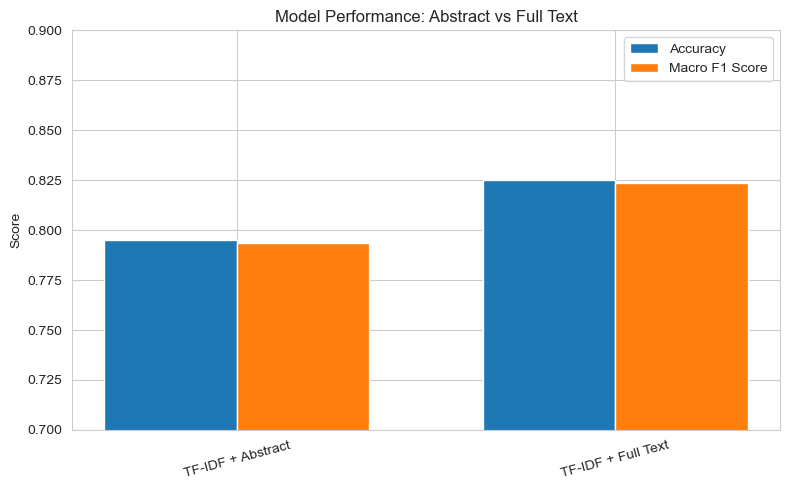

In [20]:
# Accuracy vs Macro F1 comparison bar chart
import matplotlib.pyplot as plt

# Data from summary_df
comparison_data = {
    "Input Type": ["TF-IDF + Abstract", "TF-IDF + Full Text"],
    "Accuracy": [0.795, 0.825],
    "Macro F1": [0.793603, 0.823419]
}

df_plot = pd.DataFrame(comparison_data)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
x = range(len(df_plot))

ax.bar(x, df_plot["Accuracy"], width=bar_width, label="Accuracy")
ax.bar([p + bar_width for p in x], df_plot["Macro F1"], width=bar_width, label="Macro F1 Score")

ax.set_xticks([p + bar_width/2 for p in x])
ax.set_xticklabels(df_plot["Input Type"], rotation=15)
ax.set_ylim(0.7, 0.9)
ax.set_ylabel("Score")
ax.set_title("Model Performance: Abstract vs Full Text")
ax.legend()
plt.tight_layout()
plt.show()
